# Ensemble notebook
Takes the pickles made in the evaluation notebook to average probabilities together

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext tensorboard
#%matplotlib qt

In [2]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from collections import OrderedDict
import SimpleITK as sitk
#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)
from collections import OrderedDict
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

import pickle, subprocess
import scipy
import sklearn
import csv

import torchmetrics

#import initial_ml as iml
from gbm_project import data_prep as dp
from gbm_project.pytorch.run_model_torch import RunModel
from gbm_project.pytorch import resnet_spottune as rs
from MedicalNet.models import resnet

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"using {device} device")
#torch.backends.cudnn.benchmark = False
#torch.use_deterministic_algorithms(True)

using cuda device


In [4]:
csv_dir = '../../data/upenn_GBM/csvs/radiomic_features_CaPTk/'
image_dir = '../../data/upenn_GBM/images/NIfTI-files/'
#image_dir = '../../data/upenn_GBM/numpy_conversion_all_augmented_channels_survival/'
#image_dir = '../../data/upenn_GBM/numpy_conversion_all_augmented_channels/'
#image_dir = '../../data/upenn_GBM/numpy_conversion_DSC_augmented_channels/'
#out_dir = '../../data/upenn_GBM/numpy_conversion_DTI_augmented_channels/'
out_dir = '../../data/upenn_GBM/numpy_conversion_all_augmented_channels/'
 
#modality = 'T1GD'
#modality = ['T2', 'FLAIR', 'T1', 'T1GD']
#modality = ['DSC_ap-rCBV', 'DSC_PH', 'DSC_PSR']
#modality = ['npy']
#modality = ['DTI_AD', 'DTI_FA', 'DTI_RD', 'DTI_TR']
modality = ['T2', 'FLAIR', 'T1', 'T1GD', 'DSC_ap-rCBV', 'DSC_PH', 'DSC_PSR', 'DTI_AD', 'DTI_FA', 'DTI_RD', 'DTI_TR']
#scale_file = 'image_scaling_'+modality+'.json'

##### classifiers: Survival_from_surgery_days, MGMT
#classifier = 'Survival_from_surgery_days'
classifier = 'MGMT'

#auto_df, man_df, comb_df = dp.retrieve_data(csv_dir, modality='DTI_AD')
#auto_df, man_df, comb_df = dp.retrieve_data(csv_dir, modality='T2')
#patients = dp.retrieve_patients(csv_dir, image_dir, modality='npy', classifier=classifier)
patients = dp.retrieve_patients(csv_dir, image_dir, modality=modality, classifier=classifier)

#image_df = dp.retrieve_image_data(patients, modality=modality, image_dir_=image_dir)
#path_df = dp.convert_image_data_mod(patients, modality=modality, 
#                                image_dir_=image_dir, out_dir=out_dir,
#                                image_type='mansegm',
#                                #scale_file=scale_file,
#                                window=(140, 172, 164),
#                                pad_window=(70, 86, 86),
#                                #pad_window=(36, 44, 44),
#                               #window=(64, 80, 60),
#                                base_dim=(155, 240, 240), downsample=True,
#                                window_idx = ((0, 140), (39, 211), (44,208)), down_factor=0.5,
#                                augments=('base', 'flip', 'rotate', 'noise', 'deform'), do_all=True)


In [5]:
image_dir = '../../data/upenn_GBM/numpy_conversion_DSC_augmented_channels/'
patients_1 = dp.retrieve_patients(csv_dir, image_dir, modality='npy', classifier=classifier)

In [6]:
image_dir = '../../data/upenn_GBM/numpy_conversion_struct_augmented_channels/'
patients_2 = dp.retrieve_patients(csv_dir, image_dir, modality='npy', classifier=classifier)

In [7]:
image_dir = '../../data/upenn_GBM/numpy_conversion_DTI_augmented_channels/'
patients_3 = dp.retrieve_patients(csv_dir, image_dir, modality='npy', classifier=classifier)

In [31]:
extra_dsc = [pat for pat in patients_1.index if pat not in patients_3.index]
test_dti = patients_3.drop([pat for pat in patients_3.index if pat in patients_1.index])
test_comb = test_dti.index.union(patients_1.index, sort=False)
print(test_dti.index)
print(patients_1.index)
print(test_comb)
dsc_to_remove = np.isin(test_comb, extra_dsc)
print(dsc_to_remove)

Index(['UPENN-GBM-00093_11', 'UPENN-GBM-00095_11', 'UPENN-GBM-00117_11',
       'UPENN-GBM-00124_11', 'UPENN-GBM-00136_11', 'UPENN-GBM-00147_11',
       'UPENN-GBM-00260_11', 'UPENN-GBM-00344_11', 'UPENN-GBM-00359_11',
       'UPENN-GBM-00371_11', 'UPENN-GBM-00381_11', 'UPENN-GBM-00390_11',
       'UPENN-GBM-00410_11', 'UPENN-GBM-00415_11', 'UPENN-GBM-00424_11',
       'UPENN-GBM-00430_11', 'UPENN-GBM-00438_11', 'UPENN-GBM-00447_11',
       'UPENN-GBM-00474_11', 'UPENN-GBM-00492_11', 'UPENN-GBM-00493_11',
       'UPENN-GBM-00502_11', 'UPENN-GBM-00505_11', 'UPENN-GBM-00524_11',
       'UPENN-GBM-00525_11', 'UPENN-GBM-00574_11', 'UPENN-GBM-00584_11',
       'UPENN-GBM-00585_11', 'UPENN-GBM-00587_11', 'UPENN-GBM-00591_11',
       'UPENN-GBM-00593_11'],
      dtype='object')
Index(['UPENN-GBM-00022_11', 'UPENN-GBM-00034_11', 'UPENN-GBM-00088_11',
       'UPENN-GBM-00091_11', 'UPENN-GBM-00092_11', 'UPENN-GBM-00098_11',
       'UPENN-GBM-00115_11', 'UPENN-GBM-00120_11', 'UPENN-GBM-00121_11',

In [25]:
test_comb

Index(['UPENN-GBM-00093_11', 'UPENN-GBM-00095_11', 'UPENN-GBM-00117_11',
       'UPENN-GBM-00124_11', 'UPENN-GBM-00136_11', 'UPENN-GBM-00147_11',
       'UPENN-GBM-00260_11', 'UPENN-GBM-00344_11', 'UPENN-GBM-00359_11',
       'UPENN-GBM-00371_11',
       ...
       'UPENN-GBM-00595_11', 'UPENN-GBM-00596_11', 'UPENN-GBM-00597_11',
       'UPENN-GBM-00599_11', 'UPENN-GBM-00602_11', 'UPENN-GBM-00604_11',
       'UPENN-GBM-00605_11', 'UPENN-GBM-00606_11', 'UPENN-GBM-00607_11',
       'UPENN-GBM-00608_11'],
      dtype='object', length=220)

In [33]:
test_comb[~disc_to_remove]

Index(['UPENN-GBM-00093_11', 'UPENN-GBM-00095_11', 'UPENN-GBM-00117_11',
       'UPENN-GBM-00124_11', 'UPENN-GBM-00136_11', 'UPENN-GBM-00147_11',
       'UPENN-GBM-00260_11', 'UPENN-GBM-00344_11', 'UPENN-GBM-00359_11',
       'UPENN-GBM-00371_11',
       ...
       'UPENN-GBM-00595_11', 'UPENN-GBM-00596_11', 'UPENN-GBM-00597_11',
       'UPENN-GBM-00599_11', 'UPENN-GBM-00602_11', 'UPENN-GBM-00604_11',
       'UPENN-GBM-00605_11', 'UPENN-GBM-00606_11', 'UPENN-GBM-00607_11',
       'UPENN-GBM-00608_11'],
      dtype='object', length=218)

In [24]:
patients_3.drop([pat for pat in patients_3.index if pat in patients_1.index])

,Methylated,Unmethylated
UPENN-GBM-00093_11,0,1
UPENN-GBM-00095_11,1,0
UPENN-GBM-00117_11,0,1
UPENN-GBM-00124_11,1,0
UPENN-GBM-00136_11,0,1
UPENN-GBM-00147_11,0,1
UPENN-GBM-00260_11,1,0
UPENN-GBM-00344_11,1,0
UPENN-GBM-00359_11,1,0
UPENN-GBM-00371_11,1,0


In [6]:
X_train, X_test, X_val, y_train, y_test, y_val, kfold, X_kfold, y_kfold = dp.split_image(patients)

In [10]:
print(np.sum(patients['Unmethylated']))
print(np.sum(patients['Methylated']))

127
91


In [7]:
from gbm_project.pytorch.gen_params_torch_cfg import gen_params, model_config
#model_config['no_freeze'] = ['classify', 'layer4.2', 'layer4.1']
#model_config['n_epochs'] = 80
#gen_params['to_slice'] = True
#gen_params['n_slices'] = 20
gen_params['data_dir'] = '../../data/upenn_GBM/numpy_conversion_DTI_augmented_channels/'
#gen_params['modality'] = ['DSC']
#model_config['learning_rate'] = 1e-5
#model_config['lr_sched'] = False
#model_config['spottune'] = True

In [7]:
model_test = RunModel(model_config, gen_params)

logs are located at: logs\20230605-122517
remember to set the data


In [8]:
model_test.set_model(model_name='spottune', transfer=True)
model_test.set_agent()
#model_test2 = torchvision.models.resnet50(weights='DEFAULT')

Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-04.


In [9]:
model_test.set_train_data(X_train, y_train)
model_test.set_val_data(X_val, y_val)
model_test.set_test_data(X_test, y_test)

In [10]:
all_log_paths = []
dir_paths = []
for r, dirs, _ in os.walk('./logs/'):
    for d in dirs:
        if len(d.split('_')) > 1:
            continue
        dir_paths.append(os.path.join(r, d))
for d in dir_paths:
    for r, _, f in os.walk(d):
        for f1 in f:
            if '.pth' in f1:
                all_log_paths.append(os.path.join(r, f1))
        

In [121]:
date_str = '20230616-172814'
#file = 'best_model_27_0.63_0.77_0.79.pth'
#file = 'last_model.pth'
file = 'best_model.pth'
log_dir = f"./logs/{date_str}"
log_file = f"./logs/{date_str}/{file}"
state_dict = torch.load(log_file)
state_dict['gen_params']['n_classes'] = 1
#state_dict['gen_params']['to_slice'] = True
#state_dict['gen_params']['n_slices'] = 23
state_dict['config']['log_dir'] = log_dir
model_test = RunModel(state_dict['config'], state_dict['gen_params'])
torch.manual_seed(42)
model_test.gen_params['make_augment']=False
#model_test.set_model(model_name='MedResNet50', transfer=True)
#model_test.set_model(model_name='ResNet50_torch', transfer=True)
#model_test.set_model(model_name='spottune_imagenet', transfer=True)
model_test.set_model(model_name='spottune', transfer=True)
model_test.set_agent()
patients = dp.retrieve_patients(csv_dir, state_dict['gen_params']['data_dir'], modality='npy')
X_train, X_test, X_val, y_train, y_test, y_val, kfold, X_kfold, y_kfold = dp.split_image(patients)
#    continue
model_test.seed_switch = 'high'
model_test.model.load_state_dict(state_dict['model_state_dict'])
model_test.agent.load_state_dict(state_dict['agent_state_dict'])
model_test.set_val_data(X_val, y_val)
model_test.set_test_data(X_test, y_test)

logs are located at: ./logs/20230616-172814
remember to set the data
Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-04.


In [110]:
X_kfold_val = {}
y_kfold_val = {}
for i, (train_index, val_index) in enumerate(kfold.split(X_kfold, y_kfold)):
    X_kfold_val[f"fold_{i}"] = X_kfold[val_index]
    y_kfold_val[f"fold_{i}"] = y_kfold.iloc[val_index]
    

In [111]:
fold = 4
match fold:
    case 0:
        model_test.set_val_data(X_kfold_val['fold_0'], y_kfold_val['fold_0'])
    case 1:
        model_test.set_val_data(X_kfold_val['fold_1'], y_kfold_val['fold_1'])
    case 2:
        model_test.set_val_data(X_kfold_val['fold_2'], y_kfold_val['fold_2'])
    case 3:
        model_test.set_val_data(X_kfold_val['fold_3'], y_kfold_val['fold_3'])
    case 4:
        model_test.set_val_data(X_kfold_val['fold_4'], y_kfold_val['fold_4'])

In [9]:
print(model_test.gen_params)
print(model_test.config)
print(state_dict.keys())

{'data_dir': '../../data/upenn_GBM/numpy_conversion_DSC_augmented_channels/', 'csv_dir': '../../data/upenn_GBM/csvs/radiomic_features_CaPTk/', 'modality': ['mods'], 'dim': (70, 86, 86), 'n_channels': 3, 'n_classes': 1, 'seed': 42, 'to_augment': False, 'make_augment': False, 'to_encode': False, 'to_slice': False, 'to_3D_slice': False, 'n_slices': 20, 'augment_types': ('flip', 'rotate', 'noise', 'deform')}
{'batch_size': 12, 'n_epochs': 60, 'dropout': 0.0, 'agent_dropout': 0.0, 'dilation': 1, 'l2_reg': 1e-08, 'dim': (70, 86, 86), 'learning_rate': 1e-05, 'agent_learning_rate': 0.0001, 'agent_l2_reg': 1e-08, 'no_freeze': ['conv_seg', 'layer4'], 'spottune': True, 'lr_sched': True, 'lr_factor': 0.1, 'lr_steps': [30], 'lr_patience': 5, 'gumbel_temperature': 10000.0, 'temp_steps': [0], 'temp_vals': [10000.0], 'seed_switch': 'high', 'seed_steps': [0, 50], 'seed_vals': ['high', 'mid'], 'log_dir': './logs/20230612-171046'}
dict_keys(['model_state_dict', 'agent_state_dict', 'optimizer_state_dict',

In [97]:
model_test.gen_params['seed'] = 42
torch.manual_seed(42)
model_test.seed_switch='mid'
model_test.test('val')
torch.manual_seed(42)
model_test.seed_switch = 'mid'
model_test.test('test')

D:\work\Miniconda3\envs\pytorch_gpu\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


[3/3][====================]
Avg Val   Loss: 0.821;       Val ACC: 0.615 ± 0.095;         Val AUC: 0.606 ± 0.096
[5/5][====================]
Avg Test   Loss: 1.299;       Test ACC: 0.561 ± 0.066;         Test AUC: 0.607 ± 0.065


(array(1.2992979, dtype=float32),
 array(0.5614035, dtype=float32),
 array(0.06572532, dtype=float32),
 array(0.60732317, dtype=float32),
 array(0.064683, dtype=float32))

In [98]:

torch.manual_seed(42)
model_test.seed_switch='high'
tests = model_test.test_average()
vals = model_test.test_average(data_to_use='val')

0
[5/5][====================]
Avg Test   Loss: 1.299;       Test ACC: 0.561 ± 0.066;         Test AUC: 0.607 ± 0.065
(array(1.2992979, dtype=float32), array(0.5614035, dtype=float32), array(0.06572532, dtype=float32), array(0.60732317, dtype=float32), array(0.064683, dtype=float32))
1
[5/5][====================]
Avg Test   Loss: 1.236;       Test ACC: 0.579 ± 0.065;         Test AUC: 0.606 ± 0.065
(array(1.2363166, dtype=float32), array(0.57894737, dtype=float32), array(0.06539587, dtype=float32), array(0.6060606, dtype=float32), array(0.06471952, dtype=float32))
2
[5/5][====================]
Avg Test   Loss: 1.214;       Test ACC: 0.561 ± 0.066;         Test AUC: 0.638 ± 0.064
(array(1.2137831, dtype=float32), array(0.5614035, dtype=float32), array(0.06572532, dtype=float32), array(0.6376263, dtype=float32), array(0.06366841, dtype=float32))
3
[5/5][====================]
Avg Test   Loss: 1.327;       Test ACC: 0.561 ± 0.066;         Test AUC: 0.586 ± 0.065
(array(1.3270195, dtype=floa

In [4]:
# all of the metrics used in the evaluation, can add or remove as desired
acc_fn = torchmetrics.classification.BinaryAccuracy(threshold=0.5)
auc_fn = torchmetrics.classification.BinaryAUROC()
spe_fn = torchmetrics.classification.BinarySpecificity()
pre_fn = torchmetrics.classification.BinaryPrecision()
sen_fn = torchmetrics.classification.BinaryRecall()
f1_fn = torchmetrics.classification.BinaryF1Score()
confusion = torchmetrics.classification.BinaryConfusionMatrix()
roc_fn = torchmetrics.classification.BinaryROC()

In [5]:
# resets metric functions, should be run for each successive evaluation of probabilities as values entered into functions are persistent until reset
acc_fn.reset()
auc_fn.reset()
spe_fn.reset()
sen_fn.reset()
pre_fn.reset()
f1_fn.reset()

In [6]:
#pull probability values from pkl files
# results_spottune is the location of the probability pickles
b_string_file_names = subprocess.check_output('ls -1 ./results_spottune')
file_name_list = b_string_file_names.decode().split('\n')
cwd = './results_spottune'

test_folds = {}
for name in file_name_list:
    if 'test' in name:
        with open(os.path.join(cwd,name), 'rb') as f:
            test_folds[name.replace('_test.pkl','')] = pickle.load(f)
            f.close()

In [7]:
# These lists form up the basis for various ensembles
# each list corresponds to an ensemble
dsc_mods = [
            'DSC_ap-rCBV',
            'DSC_PH',
            'DSC_PSR',
           ]
struct_mods = [
               'T2',
               'FLAIR',
               'T1',
               'T1GD',
              ]
dti_mods = [
            'DTI_AD',
            'DTI_FA',
            'DTI_RD',
            'DTI_TR',
           ]
dsc_struct = [
            'DSC_ap-rCBV',
            'DSC_PH',
            'DSC_PSR',
            'T2',
            'FLAIR',
            'T1',
            'T1GD',
             ]
dsc_dti = [
            'DSC_ap-rCBV',
            'DSC_PH',
            'DSC_PSR',
            'DTI_AD',
            'DTI_FA',
            'DTI_RD',
            'DTI_TR',
          ]
all_mods = [
            'DSC_ap-rCBV',
            'DSC_PH',
            'DSC_PSR',
            'DTI_AD',
            'DTI_FA',
            'DTI_RD',
            'DTI_TR',
            'T2',
            'FLAIR',
            'T1',
            'T1GD',
          ]
dti_struct = [
            'DTI_AD',
            'DTI_FA',
            'DTI_RD',
            'DTI_TR',
            'T2',
            'FLAIR',
            'T1',
            'T1GD',
          ]

# The name of the model to make ensembles of, refers to a specific training
trainings = [
             'M_metric',
            ]

training_sets = {}

# sets up the models that go into each ensemble
# i.e. DSC_DTI will grab the models corresponding to all of the DSC and DTI derivatives
for t in trainings:
    training_sets[f"spottune_DSC_{t}"] = [f"spottune_{m}_{t}" for m in dsc_mods]
    training_sets[f"spottune_struct_{t}"] = [f"spottune_{m}_{t}" for m in struct_mods]
    training_sets[f"spottune_DTI_{t}"] = [f"spottune_{m}_{t}" for m in dti_mods]
    training_sets[f"spottune_all_{t}"] = [f"spottune_{m}_{t}_comb_all" for m in all_mods]
    training_sets[f"spottune_DSC_DTI_{t}"] = [f"spottune_{m}_{t}_comb_dti" for m in dsc_dti]
    training_sets[f"spottune_DSC_struct_{t}"] = [f"spottune_{m}_{t}_comb_struct" for m in dsc_struct]
    training_sets[f"spottune_DTI_struct_{t}"] = [f"spottune_{m}_{t}_comb_dti_struct" for m in dti_struct]
    #training_sets[f"transfer_DSC_{t}"] = [f"transfer_{m}_{t}" for m in dsc_mods]
    #training_sets[f"transfer_DTI_{t}"] = [f"transfer_{m}_{t}" for m in dti_mods]
    #training_sets[f"transfer_struct_{t}"] = [f"transfer_{m}_{t}" for m in struct_mods]
    #training_sets[f"transfer_all_{t}"] = [f"transfer_{m}_{t}_comb_all" for m in all_mods]
    #training_sets[f"transfer_DSC_DTI_{t}"] = [f"transfer_{m}_{t}_comb_dti" for m in dsc_dti]
    #training_sets[f"transfer_DSC_struct_{t}"] = [f"transfer_{m}_{t}_comb_struct" for m in dsc_struct]
    #training_sets[f"transfer_DTI_struct_{t}"] = [f"transfer_{m}_{t}_comb_dti_struct" for m in dti_struct]
    #training_sets[f"random_DSC_{t}"] = [f"random_{m}_{t}" for m in dsc_mods]
    #training_sets[f"random_DTI_{t}"] = [f"random_{m}_{t}" for m in dti_mods]
    #training_sets[f"random_struct_{t}"] = [f"random_{m}_{t}" for m in struct_mods]
    #training_sets[f"random_all_{t}"] = [f"random_{m}_{t}_comb_all" for m in all_mods]
    #training_sets[f"random_DSC_DTI_{t}"] = [f"random_{m}_{t}_comb_dti" for m in dsc_dti]
    #training_sets[f"random_DSC_struct_{t}"] = [f"random_{m}_{t}_comb_struct" for m in dsc_struct]
    #training_sets[f"random_DTI_struct_{t}"] = [f"random_{m}_{t}_comb_dti_struct" for m in dti_struct]

In [8]:
# since the DTI and struct modalitites have more patients, these lines grab only those patients that are common to the DSC modalities in the testing dataset, dropping extra patients
# the 'spottune_...' strings reference a placeholder model for each modality, replace as necessary with your own model
dsc_pats = test_folds['spottune_DSC_PH_M_metric']['fold_0'][0]
dti_pats = test_folds['spottune_DTI_AD_M_metric']['fold_0'][0]
struct_pats = test_folds['spottune_T2_M_metric']['fold_0'][0]

# the locations of the common patients
dti_locs = [dti_pats.get_loc(pat) for pat in dsc_pats]
struct_locs = [struct_pats.get_loc(pat) for pat in dsc_pats]

In [9]:
# Calculate the average probabilities for each fold for the testing dataset
# These are averaging the 100 GS samplings into one set of probabilities for each fold

test_fold_averages = {}
fold_list = ['fold_0',
             'fold_1',
             'fold_2',
             'fold_3',
             'fold_4'
            ]
for training in test_folds:
    running_avg = []
    dsc_dti_running_avg = []
    dsc_struct_running_avg = []
    dti_struct_running_avg = []
    val_running_avg = []
    for i, fold in enumerate(fold_list):
        if fold not in test_folds[training]:
            print(f"skipping {fold} for training: {training}")
            continue
        running_avg.append(np.average(test_folds[training][f"{fold}"][1][:,0], axis=0))
        if 'DTI' in training:
            dsc_dti_running_avg.append(np.average(test_folds[training][f"{fold}"][1][:,0][:, dti_locs], axis=0))
            dti_struct_running_avg.append(np.average(test_folds[training][f"{fold}"][1][:,0][:, dti_locs], axis=0))
        if np.any([t in training for t in ['_T2_', '_FLAIR_', '_T1_', '_T1GD_']]):
            if 'DSC' in training: continue
            dsc_struct_running_avg.append(np.average(test_folds[training][f"{fold}"][1][:,0][:, struct_locs], axis=0))
            dti_struct_running_avg.append(np.average(test_folds[training][f"{fold}"][1][:,0][:, struct_locs], axis=0))

    # averaging probabilities between each fold
    test_fold_averages[training] = np.mean(running_avg, axis=0)
    if 'DSC' in training:
        test_fold_averages[f"{training}_comb_dti"] = np.mean(running_avg, axis=0) 
        test_fold_averages[f"{training}_comb_struct"] = np.mean(running_avg, axis=0) 
        test_fold_averages[f"{training}_comb_all"] = np.mean(running_avg, axis=0) 
    if np.any(dsc_dti_running_avg): 
        test_fold_averages[f"{training}_comb_dti"] = np.mean(dsc_dti_running_avg, axis=0)
        test_fold_averages[f"{training}_comb_all"] = np.mean(dsc_dti_running_avg, axis=0)
    if np.any(dsc_struct_running_avg): 
        test_fold_averages[f"{training}_comb_struct"] = np.mean(dsc_struct_running_avg, axis=0)
        test_fold_averages[f"{training}_comb_all"] = np.mean(dsc_struct_running_avg, axis=0)
    if np.any(dti_struct_running_avg): 
        test_fold_averages[f"{training}_comb_dti_struct"] = np.mean(dti_struct_running_avg, axis=0)
    val_fold_averages[training] = val_running_avg

# averaging probabilities between modalities
for s in training_sets.keys():
    test_mean_probs = [test_fold_averages[t] for t in training_sets[s]]
    test_fold_averages[f"{s}"] = np.mean(test_mean_probs, axis=0)

In [10]:
#removes extraneous items that were used for intermediate combination steps
test_fold_averages = {k:v for k,v in test_fold_averages.items() if 'comb' not in k}

In [11]:
# calculation of performance metrics
# saved to 'test_results...' file

metrics_avg = {}
for training in test_fold_averages:
    target = []
    print(training)
    # get the target values for the testing dataset
    try:
        target = test_folds[training]['fold_0'][1][:,1][0]
    except:
        # the targets are all the same, but requires a different string to pull the target from the correct location depending on the ensemble name
        if 'DSC_DTI' in training:
            target = test_folds[training.replace('DSC_DTI', 'DSC_PH')]['fold_0'][1][:,1][0]
        elif 'DSC_struct' in training:
            target = test_folds[training.replace('DSC_struct', 'DSC_PH')]['fold_0'][1][:,1][0] 
        elif 'DTI_struct' in training:
            target = test_folds[training.replace('DTI_struct', 'DSC_PH')]['fold_0'][1][:,1][0] 
        elif 'DSC_splits' in training:
            target = test_folds[training.replace('DSC_splits', 'DSC_PH_plateau_0')]['fold_0'][1][:,1][0] 
        elif 'DSC' in training:
            target = test_folds[training.replace('DSC','DSC_PH')]['fold_0'][1][:,1][0]
        elif 'struct' in training:
            target = test_folds[training.replace('struct','T2')]['fold_0'][1][:,1][0]
        elif 'DTI' in training:
            target = test_folds[training.replace('DTI','DTI_AD')]['fold_0'][1][:,1][0]
        elif 'all' in training:
            target = test_folds[training.replace('all', 'DSC_PH')]['fold_0'][1][:,1][0] 
            
        print('changing target for combined modalities')

    # calculates the different selected metrics
    acc = acc_fn(torch.tensor(test_fold_averages[training]), torch.tensor(target))
    auc = auc_fn(torch.tensor(test_fold_averages[training]), torch.tensor(target))
    spe = spe_fn(torch.tensor(test_fold_averages[training]), torch.tensor(target))
    pre = pre_fn(torch.tensor(test_fold_averages[training]), torch.tensor(target))
    sen = sen_fn(torch.tensor(test_fold_averages[training]), torch.tensor(target))
    f1 = f1_fn(torch.tensor(test_fold_averages[training]), torch.tensor(target))
    metrics_avg[training] = (acc, auc, sen, spe, pre, f1)
with open('test_results_09132023.csv', 'w', newline='') as f:
    w = csv.writer(f)
    f.write('model, ACC, AUC, SEN, SPE, PRE, F1')
    f.write('\r\n')
    for key, val in metrics_avg.items():
        w.writerow([key] + [str(v) for v in val])
    #w.writerows(metrics_avg.items())
    f.close()

random_DSC_PH_M_metric
random_DSC_PSR_M_metric
random_DSC_ap-rCBV_M_metric
random_DTI_AD_M_metric
random_DTI_FA_M_metric
random_DTI_RD_M_metric
random_DTI_TR_M_metric
random_FLAIR_M_metric
random_T1GD_M_metric
random_T1_M_metric
random_T2_M_metric
spottune_DSC_3_M_metric
spottune_DSC_PH_M_metric
spottune_DSC_PSR_M_metric
spottune_DSC_ap-rCBV_M_metric
spottune_DTI_AD_M_metric
spottune_DTI_FA_M_metric
spottune_DTI_RD_M_metric
spottune_DTI_TR_M_metric
spottune_FLAIR_M_metric
spottune_T1GD_M_metric
spottune_T1_M_metric
spottune_T2_M_metric
transfer_DSC_PH_M_metric
transfer_DSC_PSR_M_metric
transfer_DSC_ap-rCBV_M_metric
transfer_DTI_AD_M_metric
transfer_DTI_FA_M_metric
transfer_DTI_RD_M_metric
transfer_DTI_TR_M_metric
transfer_FLAIR_M_metric
transfer_T1GD_M_metric
transfer_T1_M_metric
transfer_T2_M_metric
transfer_classify_4_FLAIR_M_metric
transfer_classify_4_T1GD_M_metric
transfer_classify_4_T1_M_metric
transfer_classify_4_T2_M_metric
transfer_classify_DSC_PH_M_metric
transfer_classify_DSC

In [125]:
def normalize(weights):
    return weights / np.sum(weights)

def loss_function(weights, X, y):
    norm_weights = np.expand_dims(weights / np.sum(weights), axis=1)
    norm_weights = np.repeat(norm_weights, len(X), axis=1).T
    preds = np.average(X, axis=1, weights=norm_weights)
    return 2 - (acc_fn(torch.tensor(preds), torch.tensor(y)).numpy() + auc_fn(torch.tensor(preds), torch.tensor(y)).numpy())

In [ ]:
weights = {}
for training in val_folds:
    print(training)
    if 'spottune' not in training:
        continue
    weights[training] = {}
    for fold in val_folds[training]:
        x_vals = np.squeeze(np.array(
            [val_folds[training][fold][:, 0, i] 
             for i in range(len(val_folds[training][fold][0, 0]))]))
        y_vals = np.squeeze(np.array(
            [np.max(val_folds[training][fold][:, 1, i]) 
             for i in range(len(val_folds[training][fold][0, 1]))]))
        
        bound_w = np.array([(0., 1.) for _ in range(100)])
        search_arg = (x_vals, y_vals)
        
        results = scipy.optimize.differential_evolution(loss_function, bound_w, search_arg)
        
        weights[training][fold] = results.x

In [68]:
with open('./results_spottune/weights_acc_auc.pkl', 'wb') as f:
    pickle.dump(weights, f)
    f.close()

In [63]:
t, p = scipy.stats.ttest_ind(fold_averages['spottune_mednet_dsc'], fold_averages['random_DSC'])
print(t, p)

[2.49410164] [0.01408791]


In [100]:
x_map_keys = []
y_map_keys = []
for key in test_fold_averages.keys():
    if not(np.any([t in key for t in compare_list])): continue
    if 'transfer' in key and 'classify' not in key: continue
    if '_4_' in key: continue
    category = key.split('_')[0]
    
    mod = '+'.join(key.replace('_M_metric','').replace('_classify','').replace('all','DSC+DTI+struct').split('_')[1:])
    print(key, mod, len(mod))
    
    x_map_keys.append(f"{category} {mod}")
    y_map_keys.append(f"{category} {mod}")
    
print(len(map_keys))

random_DSC_DTI_M_metric DSC+DTI 7
random_DSC_M_metric DSC 3
random_DSC_struct_M_metric DSC+struct 10
random_DTI_M_metric DTI 3
random_DTI_struct_M_metric DTI+struct 10
random_all_M_metric DSC+DTI+struct 14
random_struct_M_metric struct 6
spottune_DSC_DTI_M_metric DSC+DTI 7
spottune_DSC_M_metric DSC 3
spottune_DSC_struct_M_metric DSC+struct 10
spottune_DTI_M_metric DTI 3
spottune_DTI_struct_M_metric DTI+struct 10
spottune_all_M_metric DSC+DTI+struct 14
spottune_struct_M_metric struct 6
transfer_classify_DSC_DTI_M_metric DSC+DTI 7
transfer_classify_DSC_M_metric DSC 3
transfer_classify_DSC_struct_M_metric DSC+struct 10
transfer_classify_DTI_M_metric DTI 3
transfer_classify_DTI_struct_M_metric DTI+struct 10
transfer_classify_all_M_metric DSC+DTI+struct 14
transfer_classify_struct_M_metric struct 6
21


In [57]:
compare_list = [
    'DSC_M',
    'DTI_M',
    'struct',
    'DSC_DTI',
    'DSC_struct',
    'DTI_struct',
    'all',
]
test_fold_averages = dict(sorted(test_fold_averages.items()))
p_avg_array = np.empty((len(map_keys), len(map_keys)))
x = 0
for i, training in enumerate(test_fold_averages):
    y=0
    for j, training_comp in enumerate(test_fold_averages):
        #if training == training_comp: continue
        #w1 = weights[training]
        #w2 = weights[training_comp]
        if not (np.any([t in training for t in compare_list]) and np.any([t in training_comp for t in compare_list])):
            continue
        if '_4_' in training or '_4_' in training_comp: continue
        if 'transfer' in training and 'classify' not in training: continue
        if 'transfer' in training_comp and 'classify' not in training_comp: continue
        pred1 = np.squeeze(test_fold_averages[training])
        pred2 = np.squeeze(test_fold_averages[training_comp])
        t, p = scipy.stats.ttest_ind(pred1, pred2)
        p_avg_array[x][y] = p
        print(f"{training}; {training_comp}: ", p)
        y += 1
    if not (np.any([t in training for t in compare_list])):
        continue
    if '_4_' in training: continue
    if 'transfer' in training and 'classify' not in training: continue
    x += 1

random_DSC_DTI_M_metric; random_DSC_DTI_M_metric:  1.0
random_DSC_DTI_M_metric; random_DSC_M_metric:  0.9997614575389673
random_DSC_DTI_M_metric; random_DSC_struct_M_metric:  0.9681966331533871
random_DSC_DTI_M_metric; random_DTI_M_metric:  0.8803335483344512
random_DSC_DTI_M_metric; random_DTI_struct_M_metric:  0.9714584807713311
random_DSC_DTI_M_metric; random_all_M_metric:  0.9787348810816869
random_DSC_DTI_M_metric; random_struct_M_metric:  0.9841407548424819
random_DSC_DTI_M_metric; spottune_DSC_DTI_M_metric:  0.03172173745835719
random_DSC_DTI_M_metric; spottune_DSC_M_metric:  0.04084578917768945
random_DSC_DTI_M_metric; spottune_DSC_struct_M_metric:  0.02978157698916712
random_DSC_DTI_M_metric; spottune_DTI_M_metric:  0.027275015899307205
random_DSC_DTI_M_metric; spottune_DTI_struct_M_metric:  0.03609632781640496
random_DSC_DTI_M_metric; spottune_all_M_metric:  0.02993288278113028
random_DSC_DTI_M_metric; spottune_struct_M_metric:  0.015866057174479576
random_DSC_DTI_M_metric; t

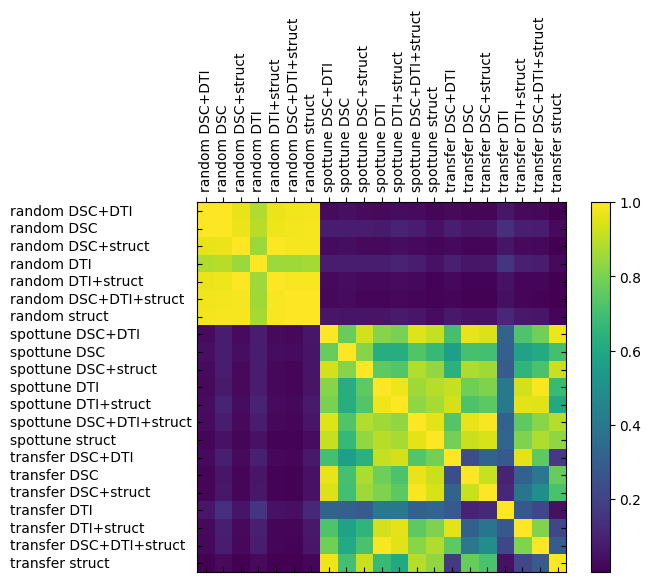

In [157]:
import mpl_toolkits.axisartist as axisartist
figure = plt.figure()
axes = figure.add_subplot(111, axes_class=axisartist.Axes)
caxes = axes.matshow(p_avg_array)
axis_len = np.arange(len(map_keys))
axes.set_xticks(axis_len)
axes.set_yticks(axis_len)
axes.set_xticklabels(x_map_keys)
axes.set_yticklabels(y_map_keys)
axes.axis['bottom'].toggle(ticklabels=False)
axes.axis['top'].toggle(ticklabels=True)
axes.axis["left"].major_ticklabels.set_ha("left")
axes.axis['top'].set_axis_direction('right')
axes.axis['top'].major_ticklabels.set_rotation(90)
axes.axis['top'].major_ticklabels.set_pad(-8)
#axes.axis["top"].major_ticklabels.set_ha("left")
figure.colorbar(caxes)
#plt.tight_layout()
plt.show()
figure.savefig('p_value_map.png', bbox_inches='tight')

In [222]:
fold_probs = {}
for training in test_folds:
    running_avg = {}
    for i in range(len(test_folds[training])):
        running_avg[f"fold_{i}"] = np.average(test_folds[training][f"fold_{i}"][:,0], axis=0)
    fold_probs[training] = running_avg

In [128]:
probs = range(len(fold_probs['spottune_mednet_dsc']['fold_0']))
targets = test_folds['spottune_mednet_dsc']['fold_0'][:,1][0] 

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(probs, targets, test_size=0.8, random_state=42, stratify=targets)

In [129]:
probs_train = {}
probs_test = {}

for fold in fold_probs['spottune_mednet_dsc']:
    probs_train[fold] = fold_probs['spottune_mednet_dsc'][fold][X_train]
    probs_test[fold] = fold_probs['spottune_mednet_dsc'][fold][X_test]

In [220]:
def normalize(weights):
    return weights / np.sum(weights)

def loss_function(weights, X, y):
    norm_weights = np.expand_dims(weights / np.sum(weights), axis=1)
    norm_weights = np.repeat(norm_weights, len(X[0]), axis=1)
    preds = np.average(np.squeeze(X), axis=0, weights=norm_weights)
    return 2 - (acc_fn(torch.tensor(preds), torch.tensor(y)).numpy() + auc_fn(torch.tensor(preds), torch.tensor(y)).numpy())
    #return 1 - acc_fn(torch.tensor(preds), torch.tensor(y)).numpy()

In [223]:

x_vals = {}
y_vals = {}
x_tests = {}
y_tests = {}
for training in test_folds:
    print(training)
    
    probs = range(len(fold_probs[training]['fold_0']))
    targets = test_folds[training]['fold_0'][:,1][0] 
    
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(probs, targets, test_size=0.8, random_state=42, stratify=targets)
    
    x_vals[training] = []
    y_vals[training] = np.squeeze(y_train)
    x_tests[training] = []
    y_tests[training] = np.squeeze(y_test)
    for fold in test_folds[training]:
        x_vals[training].append(fold_probs[training][fold][X_train])
        x_tests[training].append(fold_probs[training][fold][X_test])
        


random_DSC
random_DTI_fix
random_DTI
random_all
random_struct
spottune_imagenet_dsc
spottune_mednet_DSC_3fold
spottune_mednet_DSC_90epoch
spottune_mednet_DTI_3chan
spottune_mednet_DTI_90
spottune_mednet_DTI
spottune_mednet_all
spottune_mednet_dsc
spottune_mednet_struct_90
spottune_mednet_struct
transfer_imagenet_DSC_all
transfer_imagenet_DSC_classify4
transfer_imagenet_DSC_classify
transfer_mednet_DSC_3fold
transfer_mednet_DSC_all
transfer_mednet_DSC_classify4
transfer_mednet_DSC_classify
transfer_mednet_DTI_all
transfer_mednet_DTI_classify
transfer_mednet_sctruct_classify
transfer_mednet_struct_all


In [224]:
weights = {}
for training in test_folds:
    print(training)
    X = x_vals[training]
    y = y_vals[training]
    
    bound_w = np.array([(0., 1.) for _ in range(len(x_vals[training]))])
    search_arg = (X, y)
    
    results = scipy.optimize.differential_evolution(loss_function, bound_w, search_arg)
    
    weights[training] = results.x

random_DSC
random_DTI_fix
random_DTI
random_all
random_struct
spottune_imagenet_dsc
spottune_mednet_DSC_3fold
spottune_mednet_DSC_90epoch
spottune_mednet_DTI_3chan
spottune_mednet_DTI_90
spottune_mednet_DTI
spottune_mednet_all
spottune_mednet_dsc
spottune_mednet_struct_90
spottune_mednet_struct
transfer_imagenet_DSC_all
transfer_imagenet_DSC_classify4
transfer_imagenet_DSC_classify
transfer_mednet_DSC_3fold
transfer_mednet_DSC_all
transfer_mednet_DSC_classify4
transfer_mednet_DSC_classify
transfer_mednet_DTI_all
transfer_mednet_DTI_classify
transfer_mednet_sctruct_classify
transfer_mednet_struct_all


In [226]:
with open('./results_spottune/fold_ensemble_weights_acc_auc.pkl', 'wb') as f:
    pickle.dump(weights, f)
    f.close()

In [227]:
metrics_avg = {}
for training in test_folds:
    print(training)
    
    target = np.squeeze(y_tests[training])
    #w = normalize(weights[training])
    w = weights[training]
    
    preds = np.squeeze(np.average(x_tests[training], axis=0, weights=w))
    
    acc = acc_fn(torch.tensor(preds), torch.tensor(target))
    auc = auc_fn(torch.tensor(preds), torch.tensor(target))
    metrics_avg[training] = (acc, auc)
    

random_DSC
random_DTI_fix
random_DTI
random_all
random_struct
spottune_imagenet_dsc
spottune_mednet_DSC_3fold
spottune_mednet_DSC_90epoch
spottune_mednet_DTI_3chan
spottune_mednet_DTI_90
spottune_mednet_DTI
spottune_mednet_all
spottune_mednet_dsc
spottune_mednet_struct_90
spottune_mednet_struct
transfer_imagenet_DSC_all
transfer_imagenet_DSC_classify4
transfer_imagenet_DSC_classify
transfer_mednet_DSC_3fold
transfer_mednet_DSC_all
transfer_mednet_DSC_classify4
transfer_mednet_DSC_classify
transfer_mednet_DTI_all
transfer_mednet_DTI_classify
transfer_mednet_sctruct_classify
transfer_mednet_struct_all


In [230]:
p_array = np.empty((len(test_folds), len(test_folds)))
for i, training in enumerate(test_folds):
    for j, training_comp in enumerate(test_folds):
        #if training == training_comp: continue
        w1 = weights[training]
        w2 = weights[training_comp]
        pred1 = np.squeeze(np.average(x_tests[training], axis=0, weights=w1))
        pred2 = np.squeeze(np.average(x_tests[training_comp], axis=0, weights=w2))
        t, p = scipy.stats.ttest_ind(pred1, pred2)
        p_array[i][j] = p
        print(f"{training}; {training_comp}: ", p)

random_DSC; random_DSC:  1.0
random_DSC; random_DTI_fix:  0.8782478553584244
random_DSC; random_DTI:  0.002824665651461753
random_DSC; random_all:  0.17129951441680824
random_DSC; random_struct:  0.9223893835936549
random_DSC; spottune_imagenet_dsc:  0.020088918028734103
random_DSC; spottune_mednet_DSC_3fold:  0.32745979279950654
random_DSC; spottune_mednet_DSC_90epoch:  0.03288582087361275
random_DSC; spottune_mednet_DTI_3chan:  0.16988821701851453
random_DSC; spottune_mednet_DTI_90:  0.40935843049545106
random_DSC; spottune_mednet_DTI:  0.03081072577258239
random_DSC; spottune_mednet_all:  0.03076841836270716
random_DSC; spottune_mednet_dsc:  0.05160754992867478
random_DSC; spottune_mednet_struct_90:  0.3907378860630557
random_DSC; spottune_mednet_struct:  0.036084207450082756
random_DSC; transfer_imagenet_DSC_all:  0.625663693289572
random_DSC; transfer_imagenet_DSC_classify4:  0.003325322638227202
random_DSC; transfer_imagenet_DSC_classify:  0.034417868547875215
random_DSC; transfe

In [235]:
list(test_folds.keys())

['random_DSC',
 'random_DTI_fix',
 'random_DTI',
 'random_all',
 'random_struct',
 'spottune_imagenet_dsc',
 'spottune_mednet_DSC_3fold',
 'spottune_mednet_DSC_90epoch',
 'spottune_mednet_DTI_3chan',
 'spottune_mednet_DTI_90',
 'spottune_mednet_DTI',
 'spottune_mednet_all',
 'spottune_mednet_dsc',
 'spottune_mednet_struct_90',
 'spottune_mednet_struct',
 'transfer_imagenet_DSC_all',
 'transfer_imagenet_DSC_classify4',
 'transfer_imagenet_DSC_classify',
 'transfer_mednet_DSC_3fold',
 'transfer_mednet_DSC_all',
 'transfer_mednet_DSC_classify4',
 'transfer_mednet_DSC_classify',
 'transfer_mednet_DTI_all',
 'transfer_mednet_DTI_classify',
 'transfer_mednet_sctruct_classify',
 'transfer_mednet_struct_all']

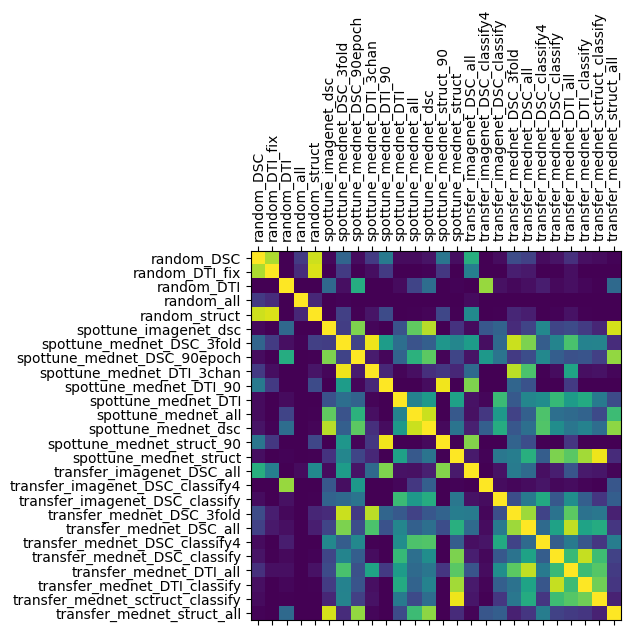

In [245]:
figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(p_array)
axis_len = np.arange(len(test_folds))
axes.set_xticks(axis_len)
axes.set_yticks(axis_len)
axes.set_xticklabels(list(test_folds.keys()), rotation = 90)
axes.set_yticklabels(list(test_folds.keys()), rotation = 0)
plt.show()

In [95]:
csv_dir = '../../data/upenn_GBM/csvs/radiomic_features_CaPTk/'
clinical_info = pd.read_csv(os.path.join(csv_dir, '../UPENN-GBM_clinical_info_v1.0.csv'))

In [96]:
clinical_info

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
...,...,...,...,...,...,...,...,...,...,...
666,UPENN-GBM-00626_21,F,57.19,Not Available,Wildtype,Unmethylated,Not Available,Not Applicable,234,5.0
667,UPENN-GBM-00627_21,F,57.40,Not Available,Wildtype,Not Available,Not Available,Not Applicable,Not Available,4.0
668,UPENN-GBM-00628_21,M,55.09,Not Available,Wildtype,Not Available,Not Available,Not Applicable,Not Available,6.0
669,UPENN-GBM-00629_21,M,71.44,Not Available,Wildtype,Unmethylated,Not Available,Not Applicable,Not Available,6.0


In [97]:
mgmt_status = (clinical_info['MGMT'] != 'Indeterminate') & (clinical_info['MGMT'] != 'Not Available')
no_duplicates = clinical_info['ID'].str.contains('_11')
clinical_info_cut = clinical_info.loc[mgmt_status & no_duplicates]
print(clinical_info.loc[mgmt_status & no_duplicates])
clinical_info_cut.set_index('ID', inplace=True)

                     ID Gender  Age_at_scan_years Survival_from_surgery_days  \
21   UPENN-GBM-00022_11      F              53.88                       1882   
33   UPENN-GBM-00034_11      F              53.63                        464   
95   UPENN-GBM-00088_11      M              47.32                        334   
99   UPENN-GBM-00091_11      M              70.54                        200   
100  UPENN-GBM-00092_11      F              66.44              Not Available   
..                  ...    ...                ...                        ...   
645  UPENN-GBM-00605_11      M              60.38              Not Available   
646  UPENN-GBM-00606_11      M              58.12              Not Available   
647  UPENN-GBM-00607_11      F              68.15              Not Available   
648  UPENN-GBM-00608_11      F              79.90              Not Available   
649  UPENN-GBM-00609_11      M              29.01                        138   

         IDH1          MGMT            

In [45]:
male = clinical_info_cut['Gender'] == 'M'
female = clinical_info_cut['Gender'] == 'F'
kps_value = clinical_info_cut['KPS'] != 'Not Available'
gtr_val = clinical_info_cut['GTR_over90percent'] != 'Not Available'
gtr_yes = clinical_info_cut['GTR_over90percent'] == 'Y'
gtr_no = clinical_info_cut['GTR_over90percent'] == ''
methylated = clinical_info_cut['MGMT'] == 'Methylated'
unmethylated = clinical_info_cut['MGMT'] == 'Unmethylated'
survival = clinical_info_cut['Survival_from_surgery_days'] != 'Not Available'

In [53]:
scaler = sklearn.preprocessing.StandardScaler()

In [98]:
age_scaled = scaler.fit_transform(clinical_info_cut['Age_at_scan_years'].to_numpy().reshape(-1,1))


In [99]:
age_scaled = pd.DataFrame(age_scaled, index=clinical_info_cut.index, columns=['Age_at_scan_years_scaled'])

In [101]:
gender_one_hot = pd.get_dummies(clinical_info_cut['Gender'])

In [105]:
clinical_inputs = pd.merge(age_scaled, gender_one_hot, how='inner', left_index=True, right_index=True)

In [107]:
clinical_inputs.to_csv(f"{csv_dir}/clinical_inputs.csv")

In [116]:
len(model_test.test_data.data_indices)

57

In [120]:
clinical_inputs.loc[model_test.test_data.data_indices]

,Age_at_scan_years_scaled,F,M
UPENN-GBM-00578_11,0.402142,0,1
UPENN-GBM-00135_11,-0.606304,0,1
UPENN-GBM-00565_11,-0.356656,1,0
UPENN-GBM-00496_11,-0.715525,1,0
UPENN-GBM-00421_11,-0.186666,0,1
UPENN-GBM-00529_11,0.827529,0,1
UPENN-GBM-00476_11,-0.192414,0,1
UPENN-GBM-00416_11,-2.089410,1,0
UPENN-GBM-00560_11,0.408712,0,1
UPENN-GBM-00508_11,-0.566886,0,1
